In [32]:
#All the import
import pandas as pd
import operator
from typing import Annotated, List, Optional, Any
import gradio as gr
import datetime
from datetime import date
import uuid
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain.vectorstores import FAISS
from langchain_community.document_loaders import NotionDirectoryLoader, NotionDBLoader
from pydantic import BaseModel, Field, ConfigDict
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
import os
from dotenv import load_dotenv
from notion_client import Client
from io import BytesIO, StringIO

In [ ]:
load_dotenv()  # This loads variables from .env into os.environ

embedding_key = os.getenv("NVIDIA_EMBEDDING_API_KEY")
client_key = os.getenv("MISTRALAI_NEMO_API_KEY")
model_key = os.getenv("LLAMA_META_API_KEY")
notion_key = os.getenv("INTEGRATION_TOKEN")
database_key = os.getenv("DATABASE_ID")
tavily_key = os.getenv("TAVILY_API_KEY")

In [9]:
#ALL Models 
embedder =  NVIDIAEmbeddings(
  model="nvidia/llama-3.2-nv-embedqa-1b-v2", 
  api_key= embedding_key, 
  truncate="NONE", 
  )

client = ChatNVIDIA(
  model="nv-mistralai/mistral-nemo-12b-instruct",
  api_key=client_key, 
  temperature=0.2,
  top_p=0.7,
  max_tokens=1024,
)

model = ChatNVIDIA(
  model="meta/llama-3.3-70b-instruct",
  api_key=model_key, 
  temperature=0.2,
  top_p=0.7,
  max_tokens=1024,
)

tavily_search = TavilySearchResults(max_results=2)

In [10]:
# We're retrieving documents from the Notion Database and then storing them in a vector store 
loader = NotionDBLoader(
    integration_token= notion_key,
    database_id=database_key,
    request_timeout_sec=30,  # optional, defaults to 10
)
docs = loader.load()

#Splitting the documents into multiple chunks for easier processing and retrieval
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", ";", ",", " ", ""],
)

def include_doc(doc):
     ## Some chunks will be overburdened with useless numerical data, so we'll filter it out
     string = doc.page_content
     if len([l for l in string if l.isalpha()]) < (len(string)//2):
         return False
     return True
    
## Some nice custom preprocessing
docs_split = text_splitter.split_documents(docs)
docs_split = [doc for doc in docs_split if include_doc(doc)]
convstore = FAISS.from_documents(docs_split, embedding=embedder)
## Retriever function to grab relevant documents from user request/input
retriever = convstore.as_retriever()

We create 2 tool functions.
1.Updates the metadata of documents from our Notion Database
2.Does websearch for up-to-date information for queries on data model hasn't been trained on

In [11]:
#Here we create our notion updating tool for our model to use

#This stores the instruction for any updates made for one specific document.
#Comes in handy when user request multiple updates for multiple documents
class update_instructions(BaseModel):
    document_name: str = Field(..., description="Name of document to update.")
    status_update: Optional[str] = None
    priority_update: Optional[str] = None
    date_update: Optional[date] =  Field(None, description="New due date in YYYY-MM-DD format.")

#Here we store a list of all the updates user is requesting for the notion database
class Update(BaseModel):
    updates: List[update_instructions] = Field(
        default_factory=list,
        description="Instructions for updating each document."
    )

#Defining our notion and database api for updates usiong notion client
notion = Client(auth=notion_key)
database_id=database_key


def update_notion(update:Update, query: str) -> str:
    """
    Updates the notion database depending on user's request
    """

    instruction_context = """
    The user will give you a list of changes to make to one or more documents in Notion.
    
    Extract and format them into a list of update instructions, where each instruction contains:
    - the name of the document (title),
    - optional status update (e.g., Done, In Progress),
    - optional priority (e.g., High, Medium, URGENT),
    - optional due date (as YYYY-MM-DD).
    """

    #We populate our Update schedma with the update_intrucstion shcema for each different document
    structured_llm = client.with_structured_output(Update)
    document_list = structured_llm.invoke(instruction_context + "\n\n" + query)

    #We now go through the list of updates/instruction and update the notion Database
    for instruction in update.updates:
        #Query the document by name
        response = notion.databases.query(
            database_id=database_id,
            filter={
                "property": "Task Names",  # Must match the column name exactly
                "title": {
                    "equals": instruction.document_name
                }
            }
        )

        #Get page_id of the document
        results = response.get("results")
        if not results:
            print(f"❌ No page found for document: {instruction.document_name}")
            continue  # Skip to next doc
        page_id = results[0]["id"]

        #We add the requested changes to document meta data here
        properties = {}
        if instruction.status_update:
            properties["Status Update"] = {"status": {"name": instruction.status_update}}

        if instruction.priority_update:
            properties["Priority Level"] = {"select": {"name": instruction.priority_update}}

        if instruction.date_update:
            properties["Due Date"] = {"date": {"start": instruction.date_update.isoformat()}}

        # Update the document meta data
        notion.pages.update(
            page_id=page_id,
            properties=properties
        )



        print(f"✅ Updated '{instruction.document_name}'")
    return "✅ All applicable documents processed."



In [12]:
#Now we create our web search tool
#This stores the search query for our websearch tool
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


def search_web(query: str) -> str:
    """
    Searches the web using Tavily based on the user’s query, then generates a response with the retrieved content.
    """
    
    search_instructions = """
    User has likely asked u information that's up to date that you do not have.
    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation/question
    """

    #This generates a search query for the tavily seach model to collect relevant information from the web
    structured_llm = client.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(search_instructions + query)

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)


    # Format Tavily results
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.get("url", "")}" title="{doc.get("title", "")}"/>\n{doc.get("content", "")}\n</Document>'
            for doc in search_docs
        ]   
    )

    to_do = """ 
    You have been given websearch results to compliment your answer to the user query.
    Make sure you are including dates and where you get the answer from.
    Make sure answer has a good flow and it makes sense and answers the query
    Summerise all your findings from the multiple sites and answer in one paragraph
    Then show a reference list of where you got all your information from
    """

    #Model response with web search results
    answer = client.invoke(to_do + formatted_search_docs + query)
    
    return  {
        "messages": answer
    }

In [13]:
#Defining Tool Function
tools = [search_web, update_notion]
client_tools = client.bind_tools(tools)

Now we start creating our Graph for the AI Agent.

First we define our graph nodes and all conditional edges to decide when each node should execute.

In [ ]:
#This stores our chatbot conversation summary
class State(MessagesState):
    summary: str

#Defining our Node/function which handles normal enquiries by user
def Normal(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"""Summary of conversation earlier. While u cannot confirm any of the AI responses, 
        assume that they are all correct {summary}"""

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    

    
    # Reconstruct the full state to pass into the tool-invoking client
    instructions = """You are a chatbot and can perform websearch. Answer the users query or input by yourself
    or with the searched documents information.
    """
    cur_time = "This is the date/time currently, use this for user query and assume this info is correct:" + datetime.datetime.now().isoformat()
    response = client_tools.invoke(cur_time + instructions + state["messages"][-1].content)

    return {
        "messages": response
    }

#This handles all queries and request relating to the Notion Database
def Notiondb(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
        
    formating = """
    You be given a information on a few documents relating to the user query.
    If user is asking information about one specific document then only give them information on that one document only. Do
    not use other documents information
    If the user is asking information about a collection of doucments then you can decide which documents user is asking for and
    use multiple documents to answer the query
    Be concise and get to the point with your answer. Then ask user if there's anything else they need
    """

    #We collect all information from vector store to answer user query
    cur_time = "This is the date/time currently, use this for user query and assume this info is correct:" + datetime.datetime.now().isoformat()
    relevant_doc = retriever.invoke(state["messages"][-1].content)
    data = [info.metadata for info in relevant_doc]
    all_metadata = [doc.metadata for doc in docs]
    context = "\n\n".join(
    f"This part belongs to the document {doc.metadata['task names']}\n\n{doc.page_content}"
    for doc in relevant_doc
    )

    #Getting model to answer/resolve user request/input
    query = cur_time + str(all_metadata) + context + "Answer the questions or update documents using information provided" + formating
    messages = state["messages"] + [HumanMessage(content=query)]
    answer = client_tools.invoke(messages)

    return  {
        "messages": answer
    }


#This helps model to decide which node/function to use depending on user input
def DecideFunction(state: State):
    instruction ="""
    Determine if user is asking/talking about general stuff or information relating to the task/documents in Notion Database. 
    You have been given a list of all the document's name from the database.
    Answer in 0 if the document or task the user is asking about is in the documents list or they mention the notion database specifically
    Only answer in 1 if the user is just making conversation.
    Make sure u only return the number either 0 or 1.
    """

    last_message = state["messages"][-1].content
    all_documents = [doc.metadata["task names"] for doc in docs]
    query = last_message + "Document names:" + str(all_documents) + instruction
    decision = client.invoke(query)
    
    if decision.content == "0":
        return "Notiondb"
    return "Normal"

#Function copied from LangGraph course with small tweaks
#This helps reduce memory storage for prolonged conversations by summerising it
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            """
            You are a chatbot and have been conversing with the user.
            Now extend the summary by taking into account the new messages above
            Do not worry about the information accuracy or anything.
            While u cannot confirm any of the AI responses, assume that they are all correct and include them in the summerisation
            Your job is to literally summerise the conversation and nothing else
            Make sure the summary isn't too long. Only use 5 sentences max and keep only key information that user can potentially reference
            later in the converstation.
            """
        )
        
    else:
        summary_message = """
        You are a chatbot and have been conversing with the user.
        Now create a summary of the conversation, do not worry about the information accuracy or anything.
        While u cannot confirm any of the AI responses, assume that they are all correct and include them in the summerisation
        Your job is to literally summerise the conversation and nothing else."""

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = client.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Function copied from LangGraph course
# This decides when the summerise function should execute to help with memory
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END


Now We create the graph structure of our AI RAG Agent

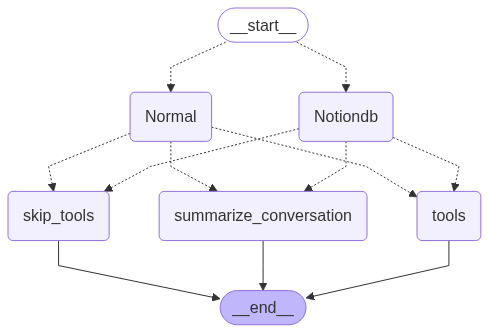

In [15]:
builder = StateGraph(State)
builder.add_node("Normal", Normal)
builder.add_node("Notiondb", Notiondb)
builder.add_node("summarize_conversation", summarize_conversation)
builder.add_node("tools", ToolNode(tools))
builder.add_node("skip_tools", lambda state: state)

def tools_condition(state):

    messages = state["messages"][-1].content  

    instruction = (
        f"From this user query: {messages} \n" 
        "decide if you already have all the information needed to complete user request."
        "Return only 0 if u don't think tools are needed. The tools you currently posses are 'notion_updater' and 'web_search' ")
    decide = model.invoke(instruction)
    if decide == "0":
        return "skip_tools"
    else:
        return "tools"



builder.add_conditional_edges(START, DecideFunction, ["Normal", "Notiondb"])

builder.add_conditional_edges("Normal", tools_condition, ["tools", "skip_tools"])
builder.add_conditional_edges("Notiondb", tools_condition, ["tools", "skip_tools"])


builder.add_conditional_edges("Normal", should_continue, ["summarize_conversation", END])
builder.add_conditional_edges("Notiondb", should_continue, ["summarize_conversation", END])



# Add
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
#graph.get_graph().print_ascii()
display(Image(graph.get_graph().draw_mermaid_png()))

Here is some example prompts and model's repsonse

In [38]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="How is the relationship between for Elon Must and Trump?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

How is the relationship between for Elon Must and Trump?
================================== Ai Message ==================================
Tool Calls:
  search_web (plfDkJh0L)
 Call ID: plfDkJh0L
  Args:
    query: Relationship between Elon Musk and Donald Trump
================================= Tool Message =================================
Name: search_web

{'messages': AIMessage(content='The relationship between Elon Musk and Donald Trump has been complex and contentious, marked by periods of mutual support and open hostility. In 2022, Musk briefly feuded with Trump, describing him as an unsuitable president due to his age after Trump had called Musk a "bullshit artist." Despite this, in July 2024, Musk publicly endorsed Trump following an assassination attempt at one of his campaign rallies. However, this endorsement did not mend their relationship, as a series of social media spats erupted between the

In [30]:
# Create a thread
input_message = HumanMessage(content="Update the Game Design document with due date to today")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

✅ Updated 'Game Design'
================================ Human Message =================================

Update the Game Design document with due date to today
================================== Ai Message ==================================
Tool Calls:
  update_notion (CF7xNhN0S)
 Call ID: CF7xNhN0S
  Args:
    update: {'updates': [{'document_name': 'Game Design', 'date_update': '2025-07-05'}]}
    query: Update Game Design document with due date to today
================================= Tool Message =================================
Name: update_notion

✅ All applicable documents processed.


In [36]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Give me a list of all task in the Notion database")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me a list of all task in the Notion database
================================== Ai Message ==================================

Here is the list of all tasks in the Notion database:

1. **Cyber report**
   - Priority: URGENT
   - Assigned to: Bike Pham
   - Status: Not started
   - Due date: September 22, 2025

2. **Business of Music**
   - Priority: High
   - Assigned to: Bachkham Pham
   - Status: Done
   - Due date: June 10, 2025

3. **ML Workshop**
   - Priority: Low
   - Assigned to: Bike Pham
   - Status: Not started
   - Due date: May 9, 2025

4. **NNO CUP RULES**
   - Priority: URGENT
   - Assigned to: Bachkham Pham, Bike Pham
   - Status: Not started
   - Due date: July 5, 2025

5. **Game Design**
   - Priority: URGENT
   - Assigned to: Bike Pham
   - Status: Done
   - Due date: July 5, 2025

6. **Information on Machine Learning**
   - Priority: High
   - Assigned to: Bachkham Pham, Bike Pham

In [35]:
graph.get_state(config).values.get("summary","")

''

In [33]:
class PipelineState(BaseModel):
    csv_path: Optional[str] = None
    csv_string: Optional[str] = None  # This replaces DataFrame
    model_config = ConfigDict(arbitrary_types_allowed=True)

    def get_df(self) -> Optional[pd.DataFrame]:
        if self.csv_string:
            return pd.read_csv(StringIO(self.csv_string))
        return None

    def set_df(self, df: pd.DataFrame):
        self.csv_string = df.to_csv(index=False)

In [34]:
def load_data_node(state: PipelineState) -> PipelineState:
    if state.csv_path:
        df = pd.read_csv(state.csv_path)
        state.set_df(df)
    return state

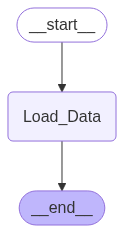

In [35]:
builder = StateGraph(PipelineState)
builder.add_node("Load_Data", load_data_node)

builder.add_edge(START, "Load_Data")
builder.add_edge("Load_Data", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
#graph.get_graph().print_ascii()
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
config = {"configurable": {"thread_id": "1"}}
output_dict = graph.invoke(PipelineState(csv_path="train.csv"), config)
output = PipelineState.model_validate(output_dict)
print("CSV Path:", output.get_df)

CSV Path: <bound method PipelineState.get_df of PipelineState(csv_path='train.csv', csv_string='TransactionNumber,UserID,Age,Gender,Occupation,EducationLevel,MaritalStatus,NumDependents,Income,Expenditure,GiftsTransaction,TransactionDate,TransactionTime,TransactionAmount,MerchantID,TransactionType,TransactionLocation,DeviceType,Latitude,Longitude,EmailDomain,Terrorism,UserTenure,IsFraud\r\n8765,70,37,Female,Professional,Bachelor,Widowed,3,28884.43 AUD,14610.61 AUD,£ 1050.01,2023-03-12,12:25:57,AU$ 258.14,M006,Withdrawal,Adelaide,Mobile,-31.840233,145.612793,jon44@disposable.com,False,113,1\r\n9645,3386,34,Male,Student,High School,Married,4,AU$ 54919.07,39169.49 AUD,£ 4969.71,2023-03-05,18:27:24,34.94 AUD,M002,Withdrawal,Canberra,Mobile,-37.0201,144.9646,emilyreese@gmail.com,False,104,1\r\n1145,2971,25,Male,Unemployed,Master,Married,2,AU$ 74728.57,55873.76 AUD,£ 1149.85,2023-11-10,17:16:56,AU$ 323.82,M008,Purchase,Brisbane,Mobile,-31.840233,145.612793,fordevan@gmail.com,False,105,0\r\n1

In [ ]:
def cleaning(state:PipelineState) -> PipelineState:
    df = state.get_df
    
    

AttributeError: 'NoneType' object has no attribute 'to_csv'